<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px\" align="left">

## Correlated Randomized Benchmarking
---

* **Last Updated:** June 20, 2020
* **Requires:** qiskit-terra 0.14, qiskit-ignis 0.3, qiskit-aer 0.5


## Introduction

**Randomization benchmarking (RB)** is a well-known technique to measure average gate performance by running sequences of random Clifford gates that should return the qubits to the initial state. 
Qiskit Ignis has tools to generate one- and two-qubit Clifford gate sequences simultaneously. If we run simultaneous RB we can look at the decay of correlated Z-Pauli's to extract the weight and locality of errors (see paper XXX).

This notebook gives an example for how to use the ``ignis.verification.randomized_benchmarking`` module to run correlated RB. This particular example shows how to run single qubit simultaneous randomized benchmarking on 5 qubits. 

In [25]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes classes
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

## Select the Parameters of the RB Run

First, wee need to choose the following parameters:

- **nseeds:** The number of seeds. For each seed there you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

In this example we have 3 qubits Q0,Q1,Q2. 
We are running 2Q RB (on qubits Q0,Q2) and 1Q RB (on qubit Q1) simultaneously, 
where there are twice as many 1Q Clifford gates.

In [26]:
##### Number of qubits
nQ = 4
#There are 4 qubits: Q0,Q1,Q2,Q3.
#Number of seeds (random sequences)
nseeds = 5 #set to 5 for testing, should be higher
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = list(np.arange(1,1200,75))
nCliffs.append(1800)
#1Q RB on Q0-4 simultaneously
rb_pattern = [[0],[1],[2],[3],[4]]

In [27]:
#load IBMQ
qiskit.IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-06-20 03:59:45,463: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [28]:
#load the backend
# Run on a noisy simulator
noise_model = NoiseModel()

# Depolarizing error on the gates u2, u3 and cx (assuming the u1 is virtual-Z gate and no error)
p1Q = 0.001
p2Q = 0.01

noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2 * p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')
backend = qiskit.Aer.get_backend('qasm_simulator')

### Create and run the measurement calibration

Measurement correction is needed because we want to measure the correlations during RB independent of any measurement correlations

In [29]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(5)
qubit_list = []
for i in rb_pattern:
    for j in i:
        qubit_list.append(j)
print(qubit_list)
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

[0, 1, 2, 3, 4]


In [30]:
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 1024
meas_calibs_trans = qiskit.compiler.transpile(meas_calibs, 
                                              backend=backend, 
                                              basis_gates=basis_gates, optimization_level=0)
qobj = qiskit.compiler.assemble(meas_calibs_trans, shots=shots)
job = backend.run(qobj)

In [31]:
print(job.job_id())

5c2042b6-509a-4610-be49-98772c50b9b0


In [32]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [33]:
# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(job.result(), state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [34]:
# Get the filter object
meas_filter = meas_fitter.filter

## Generate RB sequences

We generate RB sequences. We start with a small example (so it doesn't take too long to run).

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function **rb.randomized_benchmarking_seq**.

This function returns:

- **rb_circs:** A list of lists of circuits for the rb sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).
- **rb_opts_dict:** Option dictionary back out with default options appended.

In [35]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [36]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

In [37]:
print(len(rb_circs[0]))

17


As an example, we print the circuit corresponding to the first RB sequence

In [38]:
print(rb_circs[0][0])

      ┌───┐ ┌───┐   ░   ┌───┐ ┌───┐       ┌─┐                               
qr_0: ┤ H ├─┤ X ├───░───┤ X ├─┤ H ├───────┤M├───────────────────────────────
      ├───┤┌┴───┴┐┌───┐ └─░─┘ ├───┤ ┌───┐ └╥┘┌───┐            ┌─┐           
qr_1: ┤ H ├┤ SDG ├┤ H ├───░───┤ H ├─┤ S ├──╫─┤ H ├────────────┤M├───────────
      ├───┤└┬───┬┘└─░─┘┌─────┐├───┤ └───┘  ║ └┬─┬┘            └╥┘           
qr_2: ┤ H ├─┤ S ├───░──┤ SDG ├┤ H ├────────╫──┤M├──────────────╫────────────
      ├───┤ ├───┤ ┌───┐└──░──┘├───┤┌─────┐ ║  └╥┘  ┌───┐       ║ ┌─┐        
qr_3: ┤ H ├─┤ S ├─┤ X ├───░───┤ X ├┤ SDG ├─╫───╫───┤ H ├───────╫─┤M├────────
      ├───┤ ├───┤ ├───┤ ┌───┐ └─░─┘└┬───┬┘ ║   ║  ┌┴───┴┐┌───┐ ║ └╥┘┌───┐┌─┐
qr_4: ┤ H ├─┤ H ├─┤ S ├─┤ Z ├───░───┤ Z ├──╫───╫──┤ SDG ├┤ H ├─╫──╫─┤ H ├┤M├
      └───┘ └───┘ └───┘ └───┘   ░   └───┘  ║   ║  └─────┘└───┘ ║  ║ └───┘└╥┘
cr_0: ═════════════════════════════════════╩═══╬═══════════════╬══╬═══════╬═
                                               ║               ║  ║       ║ 

## Execute RB Circuits

We can execute the RB sequences using IBMQ provider, 
and obtain a list of results **result_list**. Here we split each seed into 2 jobs to avoid the IBMQ memory limit.

In [39]:
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 1024
result_list = []
qobj_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, backend=backend, 
                                                 basis_gates=basis_gates, optimization_level=0)
    
    inds = [[0,len(new_rb_circ_seed)-3],[len(new_rb_circ_seed)-3,len(new_rb_circ_seed)]]
    for i in range(2):
        ind1 = inds[i][0]
        ind2 = inds[i][1]
        print(ind1,ind2)
        qobj = qiskit.compiler.assemble(new_rb_circ_seed[ind1:ind2], shots=shots)
        print('Running seed %d'%rb_seed)
        job = backend.run(qobj,noise_model=noise_model)
        print(job.job_id())
        result_list.append(job.result())
        qobj_list.append(qobj)    
print("Finished Running")

Compiling seed 0
0 14
Running seed 0
d8822abe-1ff3-4f5a-9faa-46adf7f71eea
14 17
Running seed 0
d32f1759-8168-40e1-8259-3cb0f43622a6
Compiling seed 1
0 14
Running seed 1
edc2bb22-8521-401d-a78d-b68e4e61c670
14 17
Running seed 1
c25922cb-61f9-4a75-94a4-9474d622a7fa
Compiling seed 2
0 14
Running seed 2
997308b8-5620-4633-b59c-50df3dfea4ef
14 17
Running seed 2
33755602-8a25-47cd-b199-a9bdde083a4b
Compiling seed 3
0 14
Running seed 3
fad6c8e4-96c7-4311-84cc-8a09dd949347
14 17
Running seed 3
6a6c7246-c197-411f-a3ea-b2fa862f55bc
Compiling seed 4
0 14
Running seed 4
6c0ff77c-7d32-47a6-91ec-a53ffe9f452c
14 17
Running seed 4
f6a02f90-2a26-4f43-9b07-583848c0982e
Finished Running


## Get statistics about the survival probabilities

The results in **results_list** should fit to an exponentially decaying function $A \cdot \alpha ^ m + B$, where $m$ is the Clifford length.

We fit to each of the correlators.

### Fit the RB data to get the decay parameters "alpha"

In [40]:
#correct results
result_list2 = []
for result in result_list:
    result_corr = meas_filter.apply(result)
    result_list2.append(result_corr)

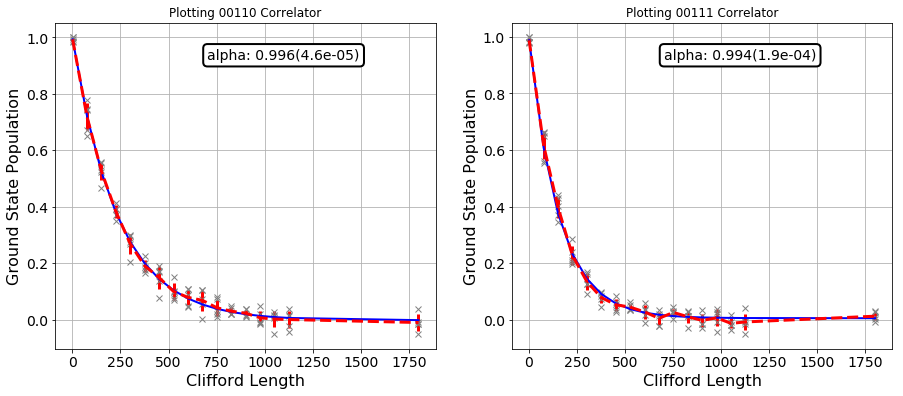

In [41]:
rbfit = rb.CorrelatedRBFitter(None, xdata, rb_opts['rb_pattern'])

for seed_num, data in enumerate(result_list2):#range(1,len(result_list)):  
    
    # Add another seed to the data
    if seed_num>-1:
        rbfit.add_data([data],rerun_fit=False)
        
rbfit.calc_data()
rbfit.calc_statistics()
rbfit.fit_data()

plt.figure(figsize=(15, 6))
axis = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
    
for i,j in enumerate(np.arange(5,7)):
    pattern_ind = j

    # Plot the essence by calling plot_rb_data
    rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

    # Add title and label
    #axis[i].set_title('%d Qubit RB - after seed %d'%(len(rb_opts['rb_pattern'][i]), seed_num), fontsize=18)

# Display
#display.display(plt.gcf())

# Clear display after each seed and close
#display.clear_output(wait=True)
#time.sleep(0.1)
#plt.close()

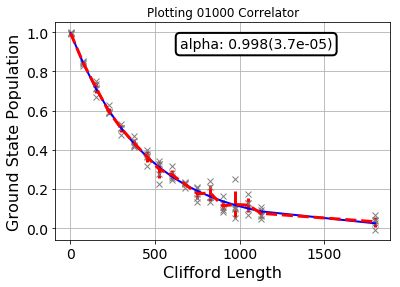

In [42]:
rbfit.plot_rb_data(7, add_label=True, show_plt=True)

In [43]:
#These are the decay parameters from the fit
rbfit.fit_alphas

{'00001': 0.9978165208716802,
 '00010': 0.9977002317880831,
 '00011': 0.9955216749429648,
 '00100': 0.997878749110293,
 '00101': 0.9957040275354174,
 '00110': 0.9957468479386672,
 '00111': 0.9935190376317105,
 '01000': 0.9977464986299114,
 '01001': 0.9955249233201535,
 '01010': 0.9955469811415738,
 '01011': 0.9935510119634108,
 '01100': 0.9955112752189106,
 '01101': 0.9935887645732216,
 '01110': 0.9933775106709769,
 '01111': 0.991656932226769,
 '10000': 0.9979088194145618,
 '10001': 0.9957189380298312,
 '10010': 0.9957401705036003,
 '10011': 0.9937805707638763,
 '10100': 0.9957684477883569,
 '10101': 0.993476007337161,
 '10110': 0.9934840882055644,
 '10111': 0.9914290501691244,
 '11000': 0.9955516184596935,
 '11001': 0.9935098921068102,
 '11010': 0.9934225990165289,
 '11011': 0.9913897036203655,
 '11100': 0.9932029433054794,
 '11101': 0.9914871872666087,
 '11110': 0.9916896440751356,
 '11111': 0.9894602280689112}

### Fit the alphas to a depolarizing map

In [44]:
rbfit.fit_alphas_to_epsilon()

2.0284072607596114e-07

In [45]:
rbfit.fit_epsilon['01000']

[0.002052591825433557, 0.00011524714241330327]

In [46]:
1-rbfit.fit_alphas['01000']

0.0022535013700886175

In [47]:
#These are the calculated decay parameters given the depolarizing probabilities 
#that the fitter returned
rbfit._calc_alphas([rbfit.fit_epsilon[i][0] for i in rbfit._subsystems])

array([0.99773637, 0.99770595, 0.9956071 , 0.99773863, 0.9956245 ,
       0.99560825, 0.99358435, 0.99761231, 0.9955341 , 0.99550539,
       0.99351046, 0.99550226, 0.9935061 , 0.99348714, 0.99153346,
       0.99775709, 0.99563525, 0.99562501, 0.99359629, 0.995618  ,
       0.99358193, 0.9935827 , 0.99159845, 0.99550129, 0.99349731,
       0.9934856 , 0.99152665, 0.99345603, 0.99150016, 0.99149701,
       0.9895631 ])

Text(0.5, 1.0, 'Qubits [0, 1, 2, 3, 4] on Backend qasm_simulator')

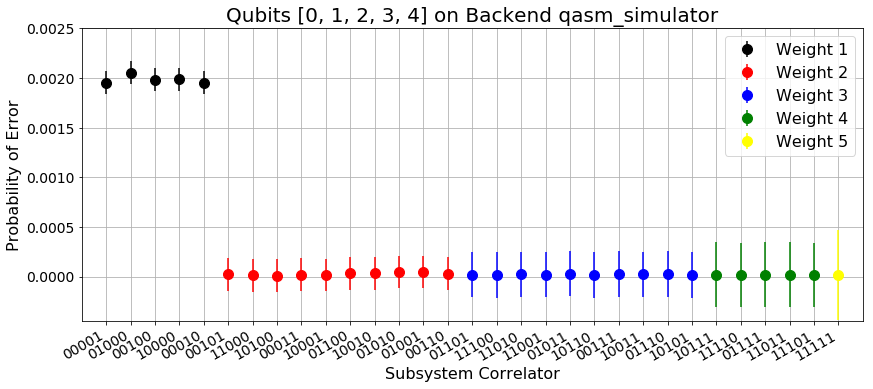

In [48]:
#Plot the depolarizing probabilities
fig = plt.figure(figsize=(14, 6))
rbfit.plot_epsilon(ax=fig.gca())
fig.gca().set_title("Qubits %s on Backend %s"%(str(qubit_list),backend.name()), fontsize=20)